### File Explanation

**trainRNN_HBTRC_EncoderModel_learningRate.ipynb:**
<br> This notebook is to load HBTRC examples from 'preprocessData_HBTRC.pickle', create an "Encoder Network" and train the network with respect to a range of learning rates

**Processes are as follows:**
<br> 1) Load all variables from 'preprocessData_HBTRC.pickle'
<br> 2) Parameter and hyperparameter assignments (location: **3rd cell**)
<br> 3) Create LSTM cells with Dropout Wrappers for gene A and gene B (function: **dropoutWrapper** in **trainRNN_network_utils.py**)
<br> 4) Using LSTM cells, create multi-layer dynamic model (function: **dynamicLSTM** using **length** in **trainRNN_network_utils.py**)
<br> 5) Create a single output based on the relevants outputs of encoder models of gene A and gene B
<br> 6) Pass the output through a **dense** layer and make prediction with **softmax**
<br> 7) Before starting the training: concatenate rSnpG_tr_nXSN and rRnaG_nXS where G represents gene A and gene B (function: **input_reshape** in **trainRNN_utils.py**)
<br> 7) Train the network: every epoch (i.e., iteration) shuffle the data within each class (function: **shuffle_classes** in **trainRNN_utils.py**) and train in batches (function: **extract_batch_size** in **trainRNN_utils.py**)
<br> 8) Plot results with **plot_inputs** in **trainRNN_plot_utils.py**)
<br> 9) Save them in "resultsEncoderLearningRate_HBTRC.pickle" to be called when necessary

**Variables created:**
<br> 1) **trainLosses**: Train losses, dictionary, keys of ([0.1, 0.01, 0.001, 0.0001, 0.00001])
<br> 2) **testLosses**: Test losses, dictionary, keys of ([0.1, 0.01, 0.001, 0.0001, 0.00001])
<br> 3) **F1_scores**: F1_scores, dictionary, keys of ([0.1, 0.01, 0.001, 0.0001, 0.00001])
<br> 4) **trainAccuracy**: Train accuracy, dictionary, keys of ([0.1, 0.01, 0.001, 0.0001, 0.00001])

In [11]:
import tensorflow as tf
from IPython.core.debugger import set_trace #set_trace()
import numpy as np
import sys
import pandas as pd
from tensorflow.contrib import rnn
import matplotlib.pyplot as plt

import os
os.environ[ "CUDA_VISIBLE_DEVICES" ] = "3"

%matplotlib inline

In [2]:
# LOAD DATA
# Load data form the pickle produced by "preprocessData_HBTRC.ipynb"

# Save data into Python file
import pickle
with open('preprocessData_HBTRC.pickle', 'rb') as f:
    rSnpA_nXSN = pickle.load( f )
    rSnpB_nXSN = pickle.load( f )
    rRnaA_nXS = pickle.load( f )
    rRnaB_nXS = pickle.load( f )
    rRelated_nXC = pickle.load( f )
    rSnpA_tr_nXSN = pickle.load( f )
    rSnpB_tr_nXSN = pickle.load( f )
    rRnaA_tr_nXS = pickle.load( f )
    rRnaB_tr_nXS = pickle.load( f )
    rRelated_tr_nXC = pickle.load( f )
    rSnpA_tst_nXSN = pickle.load( f )
    rSnpB_tst_nXSN = pickle.load( f )
    rRnaA_tst_nXS = pickle.load( f )
    rRnaB_tst_nXS = pickle.load( f )
    rRelated_tst_nXC = pickle.load( f )
    sGeneNames_nX2 = pickle.load( f )
    sGeneNames_tr_nX2 = pickle.load( f )
    sGeneNames_tst_nX2 = pickle.load( f )
    nRs = pickle.load( f )
    nSs = pickle.load( f )
    print( 'Data loaded from pickle.' )


# Check the input dimensions
assert( len( rSnpA_nXSN.shape ) == 3 )
assert( len( rSnpB_nXSN.shape ) == 3 )
assert( len( rRnaA_nXS.shape ) == 2 )
assert( len( rRnaB_nXS.shape ) == 2)
assert( len( rRelated_nXC.shape ) == 2 )
assert( len( rSnpA_tr_nXSN.shape ) == 3 )
assert( len( rSnpB_tr_nXSN.shape ) == 3 )
assert( len( rRnaA_tr_nXS.shape ) == 2 )
assert( len( rRnaB_tr_nXS.shape ) == 2 )
assert( len( rRelated_tr_nXC.shape ) == 2 )
assert( len( rSnpA_tst_nXSN.shape ) == 3 )
assert( len( rSnpB_tst_nXSN.shape ) == 3 )
assert( len( rRnaA_tst_nXS.shape ) == 2 )
assert( len( rRnaB_tst_nXS.shape ) == 2 )
assert( len( rRelated_tst_nXC.shape ) == 2)
assert( rSnpA_nXSN.shape[ 0 ] == rRnaA_nXS.shape[0] )
assert( rSnpA_nXSN.shape[ 0 ] == rRnaB_nXS.shape[0] )
assert( rSnpB_nXSN.shape[ 0 ] == rRnaA_nXS.shape[0] )
assert( rSnpB_nXSN.shape[ 0 ] == rRnaB_nXS.shape[0] )
assert( rSnpA_nXSN.shape[ 0 ] == rRelated_nXC.shape[ 0 ] )
assert( rSnpA_nXSN.shape[ 1 ] == rRnaA_nXS.shape[ 1 ] )
assert( rSnpB_nXSN.shape[ 1 ] == rRnaB_nXS.shape[ 1 ] )
assert( rRelated_nXC.shape[ 1 ] == 3 )

iSnum = rSnpA_nXSN.shape[ 1 ] # Number of subjects
iNnum = rSnpA_nXSN.shape[ 2 ] # Number of snps
iCnum = rRelated_nXC.shape[ 1 ] # Number of classes

print('All samples loaded' )
print('Number of training samples (transcripts) of gene A: {}'.format( rSnpA_tr_nXSN.shape[ 0 ] ) )
print('Number of training samples (transcripts) of gene B: {}'.format( rSnpB_tr_nXSN.shape[ 0 ] ) )
print('Number of test samples (transcripts) of gene A: {}'.format( rSnpA_tst_nXSN.shape[ 0 ] ) )
print('Number of test samples (transcripts) of gene B: {}'.format( rSnpB_tst_nXSN.shape[ 0 ] ) )
print('Number of subjects iSnum: {}'.format( rSnpA_nXSN.shape[ 1 ] ) )
print('Number of SNPs iNnum: {}'.format( rSnpA_nXSN.shape[ 2 ] ) )
print('Number of association classes iCnum: {}'.format( rRelated_nXC.shape[ 1 ] ) )

Data saved into pickle.
All samples loaded
Number of training samples (transcripts) of gene A: 1500
Number of training samples (transcripts) of gene B: 1500
Number of test samples (transcripts) of gene A: 45
Number of test samples (transcripts) of gene B: 45
Number of subjects iSnum: 434
Number of SNPs iNnum: 100
Number of association classes iCnum: 3


### Parameters

In [3]:
# Parameters

## Input data
time_steps = iNnum + 1                              # number of snps + number of rnas
n_input = iSnum                                     # number of subjects

## LSTM's internal structure
n_hidden = 32                                       # number of nodes in hidden layer 
n_classes = iCnum                                   # number of classes
n_layer = 3                                         # number of layers
dropout = 0.4                                       # dropout percentage

## Training data
learning_rates = [0.1, 0.01, 0.001, 0.0001, 0.00001]
batch_size = 150
n_epoch = 200
n_batch = rSnpA_tr_nXSN.shape[0] // batch_size   # number of batches
lambda_l2_reg = 0.0001

### Network and Train

In [9]:
%run trainRNN_utils.py
%run trainRNN_network_utils.py

trainLosses = {}
testLosses = {}
F1_scores = {}
trainAccuracy = {}
for learning_rate in learning_rates:

    # Create network
    tf.reset_default_graph()

    # Gene A and Gene B input and output placeholders
    ## Input placeholders
    with tf.variable_scope('geneA'):

        rSnpRnaA_pXNS = tf.placeholder(tf.float32, shape = [None, iNnum + 1, iSnum])

        hidden_output_A, current_state_A = dynamicLSTM(rSnpRnaA_pXNS, 
                                                       n_layer, 
                                                       n_hidden, 
                                                       dropout)
        
        lastA = last_relevant(hidden_output_A, length(rSnpRnaA_pXNS))

    with tf.variable_scope('geneB'):

        rSnpRnaB_pXNS = tf.placeholder(tf.float32, shape = [None, iNnum + 1, iSnum])

        hidden_output_B, current_state_B = dynamicLSTM(rSnpRnaB_pXNS, 
                                                       n_layer, 
                                                       n_hidden, 
                                                       dropout)
        
        lastB = last_relevant(hidden_output_B, length(rSnpRnaB_pXNS))

    last = tf.math.add(lastA, lastB)

    rRelated_pXC = tf.placeholder(tf.float32, 
                                  shape = [None, iCnum],
                                  name = 'rRelated_pXC')  

    # Dense Layer
    logit = tf.layers.dense(last,
                            units = n_classes, 
                            activation = None,
                            kernel_regularizer=tf.contrib.layers.l2_regularizer(0.3),
                            kernel_initializer = tf.initializers.random_normal() )

    prediction = tf.nn.softmax( logit )
    
    l2 = lambda_l2_reg * sum(
    tf.nn.l2_loss(tf_var)
        for tf_var in tf.trainable_variables()
        if not ("bias" in tf_var.name))

    cost = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits=prediction, 
                                                                         labels=tf.argmax(rRelated_pXC,1)) + l2)
    optimiser = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)

    # Accuracy; precision, and recall for f1 score
    correct_pred = tf.equal(tf.argmax(prediction,1), tf.argmax(rRelated_pXC,1))
    accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

    rec, rec_op = tf.metrics.recall(labels = tf.argmax(rRelated_pXC, 1), predictions = tf.argmax(prediction, 1))
    pre, pre_op = tf.metrics.precision(labels = tf.argmax(rRelated_pXC, 1), predictions = tf.argmax(prediction, 1))

    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        sess.run(tf.local_variables_initializer())

        # Train the network 
        train_losses = []
        train_accuracies = []
        train_f1_score = [None] * n_epoch
        test_losses = []
        test_accuracies = []
        test_f1_score = []

        # Reshape and retrive the merged training and test data
        rSnpRnaA_tr_nXNS = input_reshape(rSnpA_tr_nXSN, rRnaA_tr_nXS)
        rSnpRnaB_tr_nXNS = input_reshape(rSnpB_tr_nXSN, rRnaB_tr_nXS)
        rSnpRnaA_tst_nXNS = input_reshape(rSnpA_tst_nXSN, rRnaA_tst_nXS)
        rSnpRnaB_tst_nXNS = input_reshape(rSnpB_tst_nXSN, rRnaB_tst_nXS)

        for epoch_idx in range(n_epoch): 

            print("Data shuffled." + \
                  " Epoch: ", epoch_idx)

            # Shuffle classes
            rSnpRnaA_tr_nXNS, rSnpRnaB_tr_nXNS = shuffle_classes(rSnpRnaA_tr_nXNS, rSnpRnaB_tr_nXNS)

            for batch_idx in range(n_batch):

                batch_rSnpRnaA_tXNS = extract_batch_size(rSnpRnaA_tr_nXNS, batch_idx, batch_size)
                batch_rSnpRnaB_tXNS = extract_batch_size(rSnpRnaB_tr_nXNS, batch_idx, batch_size)
                batch_rRelated_tXC = extract_batch_size(rRelated_tr_nXC, batch_idx, batch_size)

                # Fit training data
                opt, tr_loss, tr_acc = sess.run(
                    [optimiser, cost, accuracy], 
                    feed_dict = {
                        rSnpRnaA_pXNS: batch_rSnpRnaA_tXNS,
                        rSnpRnaB_pXNS: batch_rSnpRnaB_tXNS,
                        rRelated_pXC: batch_rRelated_tXC        
                    })

                tst_loss, tst_acc, tst_pre, _, tst_rec, _ = sess.run(
                    [cost, accuracy, pre, pre_op, rec, rec_op],
                    feed_dict = {
                        rSnpRnaA_pXNS: rSnpRnaA_tst_nXNS,
                        rSnpRnaB_pXNS: rSnpRnaB_tst_nXNS,
                        rRelated_pXC: rRelated_tst_nXC
                    })            

                if batch_idx == (n_batch - 1):

                    train_losses.append(tr_loss)
                    train_accuracies.append(tr_acc)

                    tst_f1_score = 2 * ( tst_rec * tst_pre ) / (tst_rec + tst_pre) 

                    test_losses.append(tst_loss)
                    test_f1_score.append(tst_f1_score)

            print("Performance on training data" + 
                 ": Loss = {}".format(tr_loss) + 
                 ": Accuracy = {}".format( tr_acc ) )

            print("Performance on test set: " + 
                  ": Loss = {}".format(tst_loss) + 
                  ": Accuracy = {}".format(tst_f1_score) )
            print("")
    
        trainLosses[learning_rate] = train_losses
        testLosses[learning_rate] = test_losses
        trainAccuracy[learning_rate] = train_accuracies
        F1_scores[learning_rate] = test_f1_score
        print("Optimisation finished!")
        

Data shuffled. Epoch:  0
Performance on training data: Loss = 1.645053744316101: Accuracy = 0.3466666638851166
Performance on test set: : Loss = 1.6699632406234741: Accuracy = 0.6365348320795675

Data shuffled. Epoch:  1
Performance on training data: Loss = 1.7501220703125: Accuracy = 0.36000001430511475
Performance on test set: : Loss = 1.75575852394104: Accuracy = 0.6229819911932449

Data shuffled. Epoch:  2
Performance on training data: Loss = 1.647853136062622: Accuracy = 0.3933333456516266
Performance on test set: : Loss = 1.6809113025665283: Accuracy = 0.6182728424279151

Data shuffled. Epoch:  3
Performance on training data: Loss = 1.6642383337020874: Accuracy = 0.3266666531562805
Performance on test set: : Loss = 1.632938265800476: Accuracy = 0.6192007452451567

Data shuffled. Epoch:  4
Performance on training data: Loss = 1.5312412977218628: Accuracy = 0.46000000834465027
Performance on test set: : Loss = 1.6213924884796143: Accuracy = 0.6342328953894709

Data shuffled. Epoch:

Performance on training data: Loss = 2.4914464950561523: Accuracy = 0.5133333206176758
Performance on test set: : Loss = 2.5193424224853516: Accuracy = 0.6184869793253929

Data shuffled. Epoch:  43
Performance on training data: Loss = 2.5448124408721924: Accuracy = 0.4266666769981384
Performance on test set: : Loss = 2.543637275695801: Accuracy = 0.6238338858735681

Data shuffled. Epoch:  44
Performance on training data: Loss = 2.3322935104370117: Accuracy = 0.47333332896232605
Performance on test set: : Loss = 2.6071722507476807: Accuracy = 0.6266671830794388

Data shuffled. Epoch:  45
Performance on training data: Loss = 2.1489098072052: Accuracy = 0.5533333420753479
Performance on test set: : Loss = 2.285797595977783: Accuracy = 0.6266532931369736

Data shuffled. Epoch:  46
Performance on training data: Loss = 2.1348929405212402: Accuracy = 0.4933333396911621
Performance on test set: : Loss = 2.2396163940429688: Accuracy = 0.6280772775611485

Data shuffled. Epoch:  47
Performance on

Performance on training data: Loss = 1.5899436473846436: Accuracy = 0.5600000023841858
Performance on test set: : Loss = 1.791710615158081: Accuracy = 0.6112320191091725

Data shuffled. Epoch:  85
Performance on training data: Loss = 1.5463625192642212: Accuracy = 0.6000000238418579
Performance on test set: : Loss = 1.7228201627731323: Accuracy = 0.6116807180622394

Data shuffled. Epoch:  86
Performance on training data: Loss = 1.5331777334213257: Accuracy = 0.5266666412353516
Performance on test set: : Loss = 1.7789050340652466: Accuracy = 0.6113084105083666

Data shuffled. Epoch:  87
Performance on training data: Loss = 1.6032230854034424: Accuracy = 0.5666666626930237
Performance on test set: : Loss = 1.8168833255767822: Accuracy = 0.6097222040072063

Data shuffled. Epoch:  88
Performance on training data: Loss = 1.5726722478866577: Accuracy = 0.6200000047683716
Performance on test set: : Loss = 1.8926479816436768: Accuracy = 0.6090917108664202

Data shuffled. Epoch:  89
Performance

Performance on training data: Loss = 1.392960786819458: Accuracy = 0.5533333420753479
Performance on test set: : Loss = 1.5836617946624756: Accuracy = 0.6115993347105529

Data shuffled. Epoch:  127
Performance on training data: Loss = 1.3924108743667603: Accuracy = 0.5199999809265137
Performance on test set: : Loss = 1.5738966464996338: Accuracy = 0.613277626757746

Data shuffled. Epoch:  128
Performance on training data: Loss = 1.3676241636276245: Accuracy = 0.5266666412353516
Performance on test set: : Loss = 1.4305987358093262: Accuracy = 0.6150390099906367

Data shuffled. Epoch:  129
Performance on training data: Loss = 1.443966269493103: Accuracy = 0.5
Performance on test set: : Loss = 1.5916502475738525: Accuracy = 0.6166978708942583

Data shuffled. Epoch:  130
Performance on training data: Loss = 1.4480663537979126: Accuracy = 0.54666668176651
Performance on test set: : Loss = 1.5495212078094482: Accuracy = 0.6184730540245397

Data shuffled. Epoch:  131
Performance on training d

Performance on training data: Loss = 1.5189621448516846: Accuracy = 0.46000000834465027
Performance on test set: : Loss = 1.5858508348464966: Accuracy = 0.661400731559194

Data shuffled. Epoch:  169
Performance on training data: Loss = 1.3919438123703003: Accuracy = 0.5666666626930237
Performance on test set: : Loss = 1.5961871147155762: Accuracy = 0.6623300166374737

Data shuffled. Epoch:  170
Performance on training data: Loss = 1.4533593654632568: Accuracy = 0.5333333611488342
Performance on test set: : Loss = 1.6546165943145752: Accuracy = 0.6628770866360433

Data shuffled. Epoch:  171
Performance on training data: Loss = 1.3803695440292358: Accuracy = 0.54666668176651
Performance on test set: : Loss = 1.589839220046997: Accuracy = 0.6632430663792905

Data shuffled. Epoch:  172
Performance on training data: Loss = 1.4317185878753662: Accuracy = 0.5333333611488342
Performance on test set: : Loss = 1.6506174802780151: Accuracy = 0.6638087294933083

Data shuffled. Epoch:  173
Performa

Performance on training data: Loss = 0.9846954345703125: Accuracy = 0.5799999833106995
Performance on test set: : Loss = 1.2217317819595337: Accuracy = 0.4488406391261167

Data shuffled. Epoch:  11
Performance on training data: Loss = 1.0467572212219238: Accuracy = 0.5
Performance on test set: : Loss = 1.2484489679336548: Accuracy = 0.4373890951527525

Data shuffled. Epoch:  12
Performance on training data: Loss = 0.9376454949378967: Accuracy = 0.6466666460037231
Performance on test set: : Loss = 1.2520904541015625: Accuracy = 0.4258135490040614

Data shuffled. Epoch:  13
Performance on training data: Loss = 0.972186803817749: Accuracy = 0.5866666436195374
Performance on test set: : Loss = 1.2022154331207275: Accuracy = 0.41824437970946404

Data shuffled. Epoch:  14
Performance on training data: Loss = 0.9927310943603516: Accuracy = 0.6066666841506958
Performance on test set: : Loss = 1.2438766956329346: Accuracy = 0.40849408759151296

Data shuffled. Epoch:  15
Performance on training 

Performance on training data: Loss = 0.9838197827339172: Accuracy = 0.6333333253860474
Performance on test set: : Loss = 1.2360546588897705: Accuracy = 0.32359573898282146

Data shuffled. Epoch:  53
Performance on training data: Loss = 0.9538100361824036: Accuracy = 0.653333306312561
Performance on test set: : Loss = 1.27315092086792: Accuracy = 0.3236306392261852

Data shuffled. Epoch:  54
Performance on training data: Loss = 0.9116226434707642: Accuracy = 0.7133333086967468
Performance on test set: : Loss = 1.1601461172103882: Accuracy = 0.3256374479496015

Data shuffled. Epoch:  55
Performance on training data: Loss = 0.8646506667137146: Accuracy = 0.753333330154419
Performance on test set: : Loss = 1.1023677587509155: Accuracy = 0.33061282401813163

Data shuffled. Epoch:  56
Performance on training data: Loss = 0.9900698065757751: Accuracy = 0.6333333253860474
Performance on test set: : Loss = 1.1172659397125244: Accuracy = 0.3361647051965925

Data shuffled. Epoch:  57
Performance 

Performance on training data: Loss = 1.0314576625823975: Accuracy = 0.6066666841506958
Performance on test set: : Loss = 1.2549080848693848: Accuracy = 0.40876436360855123

Data shuffled. Epoch:  95
Performance on training data: Loss = 0.9265070557594299: Accuracy = 0.753333330154419
Performance on test set: : Loss = 1.213219165802002: Accuracy = 0.41130874561461395

Data shuffled. Epoch:  96
Performance on training data: Loss = 1.0221527814865112: Accuracy = 0.6200000047683716
Performance on test set: : Loss = 1.273598551750183: Accuracy = 0.4131457464976364

Data shuffled. Epoch:  97
Performance on training data: Loss = 1.060202717781067: Accuracy = 0.5866666436195374
Performance on test set: : Loss = 1.2852057218551636: Accuracy = 0.4133131621788279

Data shuffled. Epoch:  98
Performance on training data: Loss = 1.0479142665863037: Accuracy = 0.5866666436195374
Performance on test set: : Loss = 1.2472671270370483: Accuracy = 0.41482930359699466

Data shuffled. Epoch:  99
Performance

Performance on training data: Loss = 0.9120221138000488: Accuracy = 0.7400000095367432
Performance on test set: : Loss = 1.1988557577133179: Accuracy = 0.47112589734361937

Data shuffled. Epoch:  137
Performance on training data: Loss = 0.9465103149414062: Accuracy = 0.7200000286102295
Performance on test set: : Loss = 1.2381752729415894: Accuracy = 0.4729198728467595

Data shuffled. Epoch:  138
Performance on training data: Loss = 0.9702004790306091: Accuracy = 0.6666666865348816
Performance on test set: : Loss = 1.2285385131835938: Accuracy = 0.4748555012355121

Data shuffled. Epoch:  139
Performance on training data: Loss = 0.9488589763641357: Accuracy = 0.7333333492279053
Performance on test set: : Loss = 1.261889100074768: Accuracy = 0.4761531203358681

Data shuffled. Epoch:  140
Performance on training data: Loss = 0.9537164568901062: Accuracy = 0.7200000286102295
Performance on test set: : Loss = 1.2451379299163818: Accuracy = 0.47812540317586294

Data shuffled. Epoch:  141
Perf

Performance on training data: Loss = 0.9793689846992493: Accuracy = 0.7266666889190674
Performance on test set: : Loss = 1.3310716152191162: Accuracy = 0.5234054088948753

Data shuffled. Epoch:  179
Performance on training data: Loss = 0.9833678007125854: Accuracy = 0.7200000286102295
Performance on test set: : Loss = 1.3815943002700806: Accuracy = 0.523341809103864

Data shuffled. Epoch:  180
Performance on training data: Loss = 0.9946998953819275: Accuracy = 0.699999988079071
Performance on test set: : Loss = 1.3428112268447876: Accuracy = 0.5235215253953883

Data shuffled. Epoch:  181
Performance on training data: Loss = 0.9649312496185303: Accuracy = 0.7400000095367432
Performance on test set: : Loss = 1.2417004108428955: Accuracy = 0.5240176758889147

Data shuffled. Epoch:  182
Performance on training data: Loss = 0.9290316700935364: Accuracy = 0.7866666913032532
Performance on test set: : Loss = 1.3025107383728027: Accuracy = 0.5241942994901124

Data shuffled. Epoch:  183
Perform

Performance on training data: Loss = 0.8884644508361816: Accuracy = 0.6266666650772095
Performance on test set: : Loss = 1.0429764986038208: Accuracy = 0.6456874929007483

Data shuffled. Epoch:  21
Performance on training data: Loss = 0.8721390962600708: Accuracy = 0.7066666483879089
Performance on test set: : Loss = 1.0712077617645264: Accuracy = 0.6467940345555601

Data shuffled. Epoch:  22
Performance on training data: Loss = 0.8908002972602844: Accuracy = 0.6933333277702332
Performance on test set: : Loss = 1.0229939222335815: Accuracy = 0.6486926396590155

Data shuffled. Epoch:  23
Performance on training data: Loss = 0.8662773370742798: Accuracy = 0.699999988079071
Performance on test set: : Loss = 1.0235897302627563: Accuracy = 0.6496944659648141

Data shuffled. Epoch:  24
Performance on training data: Loss = 0.867978036403656: Accuracy = 0.6733333468437195
Performance on test set: : Loss = 1.0115927457809448: Accuracy = 0.6524907707823967

Data shuffled. Epoch:  25
Performance 

Performance on training data: Loss = 0.7423409223556519: Accuracy = 0.8333333134651184
Performance on test set: : Loss = 1.0334299802780151: Accuracy = 0.6911276026569272

Data shuffled. Epoch:  63
Performance on training data: Loss = 0.7971084713935852: Accuracy = 0.7866666913032532
Performance on test set: : Loss = 1.013167142868042: Accuracy = 0.6912119100500684

Data shuffled. Epoch:  64
Performance on training data: Loss = 0.8288640379905701: Accuracy = 0.7333333492279053
Performance on test set: : Loss = 1.015607237815857: Accuracy = 0.6919340038815284

Data shuffled. Epoch:  65
Performance on training data: Loss = 0.775065541267395: Accuracy = 0.8066666722297668
Performance on test set: : Loss = 1.0175939798355103: Accuracy = 0.6917597029012034

Data shuffled. Epoch:  66
Performance on training data: Loss = 0.8353613018989563: Accuracy = 0.746666669845581
Performance on test set: : Loss = 1.0427567958831787: Accuracy = 0.6921350630167213

Data shuffled. Epoch:  67
Performance on

Performance on training data: Loss = 0.745649516582489: Accuracy = 0.846666693687439
Performance on test set: : Loss = 1.0619343519210815: Accuracy = 0.7079785499384555

Data shuffled. Epoch:  105
Performance on training data: Loss = 0.7601510882377625: Accuracy = 0.8266666531562805
Performance on test set: : Loss = 1.0880858898162842: Accuracy = 0.708342982603484

Data shuffled. Epoch:  106
Performance on training data: Loss = 0.7300896644592285: Accuracy = 0.8600000143051147
Performance on test set: : Loss = 1.0526987314224243: Accuracy = 0.7088052947487223

Data shuffled. Epoch:  107
Performance on training data: Loss = 0.7678375244140625: Accuracy = 0.8133333325386047
Performance on test set: : Loss = 1.1008846759796143: Accuracy = 0.7089983748571741

Data shuffled. Epoch:  108
Performance on training data: Loss = 0.7550570964813232: Accuracy = 0.8133333325386047
Performance on test set: : Loss = 1.0971709489822388: Accuracy = 0.709145677528118

Data shuffled. Epoch:  109
Performan

Performance on training data: Loss = 0.6810910105705261: Accuracy = 0.8999999761581421
Performance on test set: : Loss = 1.0304409265518188: Accuracy = 0.72322702517218

Data shuffled. Epoch:  147
Performance on training data: Loss = 0.724202573299408: Accuracy = 0.8533333539962769
Performance on test set: : Loss = 1.0508785247802734: Accuracy = 0.7234606293930378

Data shuffled. Epoch:  148
Performance on training data: Loss = 0.7027536630630493: Accuracy = 0.8733333349227905
Performance on test set: : Loss = 1.0096009969711304: Accuracy = 0.7237347565367379

Data shuffled. Epoch:  149
Performance on training data: Loss = 0.736190676689148: Accuracy = 0.8533333539962769
Performance on test set: : Loss = 1.0117664337158203: Accuracy = 0.7239963695165658

Data shuffled. Epoch:  150
Performance on training data: Loss = 0.7319265007972717: Accuracy = 0.8399999737739563
Performance on test set: : Loss = 1.015798568725586: Accuracy = 0.7243992607487099

Data shuffled. Epoch:  151
Performanc

Performance on training data: Loss = 0.7175665497779846: Accuracy = 0.8533333539962769
Performance on test set: : Loss = 1.1236027479171753: Accuracy = 0.7245328957737581

Data shuffled. Epoch:  189
Performance on training data: Loss = 0.7076128125190735: Accuracy = 0.8600000143051147
Performance on test set: : Loss = 1.042720079421997: Accuracy = 0.7244732395071853

Data shuffled. Epoch:  190
Performance on training data: Loss = 0.706591010093689: Accuracy = 0.8733333349227905
Performance on test set: : Loss = 1.1193630695343018: Accuracy = 0.7245251097589719

Data shuffled. Epoch:  191
Performance on training data: Loss = 0.7411330938339233: Accuracy = 0.8266666531562805
Performance on test set: : Loss = 1.0840407609939575: Accuracy = 0.7246535821087534

Data shuffled. Epoch:  192
Performance on training data: Loss = 0.7593216896057129: Accuracy = 0.8199999928474426
Performance on test set: : Loss = 1.0791351795196533: Accuracy = 0.7246675898294653

Data shuffled. Epoch:  193
Perform

Performance on training data: Loss = 0.9937402606010437: Accuracy = 0.5400000214576721
Performance on test set: : Loss = 1.18694269657135: Accuracy = 0.5502368637617633

Data shuffled. Epoch:  31
Performance on training data: Loss = 0.999869704246521: Accuracy = 0.5333333611488342
Performance on test set: : Loss = 1.2108787298202515: Accuracy = 0.5487330715602212

Data shuffled. Epoch:  32
Performance on training data: Loss = 0.9953433275222778: Accuracy = 0.6066666841506958
Performance on test set: : Loss = 1.161125898361206: Accuracy = 0.5481083274219958

Data shuffled. Epoch:  33
Performance on training data: Loss = 0.968227207660675: Accuracy = 0.5799999833106995
Performance on test set: : Loss = 1.1562273502349854: Accuracy = 0.5469105968145527

Data shuffled. Epoch:  34
Performance on training data: Loss = 0.9873062968254089: Accuracy = 0.6133333444595337
Performance on test set: : Loss = 1.1275486946105957: Accuracy = 0.5488588251170792

Data shuffled. Epoch:  35
Performance on 

Performance on training data: Loss = 0.8858089447021484: Accuracy = 0.6733333468437195
Performance on test set: : Loss = 1.1757429838180542: Accuracy = 0.591461277806415

Data shuffled. Epoch:  73
Performance on training data: Loss = 0.9040607810020447: Accuracy = 0.653333306312561
Performance on test set: : Loss = 1.1655333042144775: Accuracy = 0.5922640755627122

Data shuffled. Epoch:  74
Performance on training data: Loss = 0.9204510450363159: Accuracy = 0.6666666865348816
Performance on test set: : Loss = 1.1672461032867432: Accuracy = 0.5919603324145735

Data shuffled. Epoch:  75
Performance on training data: Loss = 0.9169498682022095: Accuracy = 0.6399999856948853
Performance on test set: : Loss = 1.1744914054870605: Accuracy = 0.5919381377193257

Data shuffled. Epoch:  76
Performance on training data: Loss = 0.8945931792259216: Accuracy = 0.6733333468437195
Performance on test set: : Loss = 1.1779593229293823: Accuracy = 0.5921117891801418

Data shuffled. Epoch:  77
Performance 

Performance on training data: Loss = 0.9116281270980835: Accuracy = 0.6866666674613953
Performance on test set: : Loss = 1.1849322319030762: Accuracy = 0.6023674026346867

Data shuffled. Epoch:  115
Performance on training data: Loss = 0.9120419025421143: Accuracy = 0.6600000262260437
Performance on test set: : Loss = 1.1720561981201172: Accuracy = 0.6024533499304962

Data shuffled. Epoch:  116
Performance on training data: Loss = 0.891869306564331: Accuracy = 0.6266666650772095
Performance on test set: : Loss = 1.1265126466751099: Accuracy = 0.6029058230555765

Data shuffled. Epoch:  117
Performance on training data: Loss = 0.90329509973526: Accuracy = 0.6466666460037231
Performance on test set: : Loss = 1.165318250656128: Accuracy = 0.6032439070114765

Data shuffled. Epoch:  118
Performance on training data: Loss = 0.9183813333511353: Accuracy = 0.6733333468437195
Performance on test set: : Loss = 1.1604560613632202: Accuracy = 0.6027522665739155

Data shuffled. Epoch:  119
Performan

Performance on training data: Loss = 0.8884608149528503: Accuracy = 0.6733333468437195
Performance on test set: : Loss = 1.158690094947815: Accuracy = 0.6026398824932148

Data shuffled. Epoch:  157
Performance on training data: Loss = 0.8515352010726929: Accuracy = 0.7133333086967468
Performance on test set: : Loss = 1.2343531847000122: Accuracy = 0.6025613970814642

Data shuffled. Epoch:  158
Performance on training data: Loss = 0.8531597256660461: Accuracy = 0.7733333110809326
Performance on test set: : Loss = 1.1638349294662476: Accuracy = 0.6024010732118702

Data shuffled. Epoch:  159
Performance on training data: Loss = 0.8741607666015625: Accuracy = 0.6733333468437195
Performance on test set: : Loss = 1.171464443206787: Accuracy = 0.6018946057630222

Data shuffled. Epoch:  160
Performance on training data: Loss = 0.9171300530433655: Accuracy = 0.6266666650772095
Performance on test set: : Loss = 1.0957245826721191: Accuracy = 0.6017361822898627

Data shuffled. Epoch:  161
Perform

Performance on training data: Loss = 0.862628161907196: Accuracy = 0.7200000286102295
Performance on test set: : Loss = 1.1242680549621582: Accuracy = 0.5983993442610023

Data shuffled. Epoch:  199
Performance on training data: Loss = 0.8481638431549072: Accuracy = 0.746666669845581
Performance on test set: : Loss = 1.174142599105835: Accuracy = 0.5981954040861749

Optimisation finished!
Data shuffled. Epoch:  0
Performance on training data: Loss = 1.1655516624450684: Accuracy = 0.3466666638851166
Performance on test set: : Loss = 1.1221884489059448: Accuracy = 0.5133928909010277

Data shuffled. Epoch:  1
Performance on training data: Loss = 1.1817686557769775: Accuracy = 0.30666667222976685
Performance on test set: : Loss = 1.1124358177185059: Accuracy = 0.5173501399252132

Data shuffled. Epoch:  2
Performance on training data: Loss = 1.1486355066299438: Accuracy = 0.35333332419395447
Performance on test set: : Loss = 1.1741622686386108: Accuracy = 0.5326975016077948

Data shuffled. E

Performance on training data: Loss = 1.0840927362442017: Accuracy = 0.4466666579246521
Performance on test set: : Loss = 1.1702240705490112: Accuracy = 0.6183243175715339

Data shuffled. Epoch:  41
Performance on training data: Loss = 1.0828224420547485: Accuracy = 0.4533333480358124
Performance on test set: : Loss = 1.142484426498413: Accuracy = 0.6189220804764681

Data shuffled. Epoch:  42
Performance on training data: Loss = 1.0922865867614746: Accuracy = 0.46000000834465027
Performance on test set: : Loss = 1.1237634420394897: Accuracy = 0.6191366142227913

Data shuffled. Epoch:  43
Performance on training data: Loss = 1.0974339246749878: Accuracy = 0.3799999952316284
Performance on test set: : Loss = 1.1758688688278198: Accuracy = 0.6190591825859109

Data shuffled. Epoch:  44
Performance on training data: Loss = 1.0605212450027466: Accuracy = 0.5199999809265137
Performance on test set: : Loss = 1.1368762254714966: Accuracy = 0.6186918626610034

Data shuffled. Epoch:  45
Performanc

Performance on training data: Loss = 1.0140116214752197: Accuracy = 0.5666666626930237
Performance on test set: : Loss = 1.179417610168457: Accuracy = 0.6165676734293165

Data shuffled. Epoch:  83
Performance on training data: Loss = 1.0315665006637573: Accuracy = 0.4933333396911621
Performance on test set: : Loss = 1.1675347089767456: Accuracy = 0.6158510582292944

Data shuffled. Epoch:  84
Performance on training data: Loss = 1.0268827676773071: Accuracy = 0.4866666793823242
Performance on test set: : Loss = 1.169265866279602: Accuracy = 0.6154333629431261

Data shuffled. Epoch:  85
Performance on training data: Loss = 1.0097745656967163: Accuracy = 0.5600000023841858
Performance on test set: : Loss = 1.1656936407089233: Accuracy = 0.6151920158343871

Data shuffled. Epoch:  86
Performance on training data: Loss = 1.0124049186706543: Accuracy = 0.5533333420753479
Performance on test set: : Loss = 1.1735267639160156: Accuracy = 0.6153655949715229

Data shuffled. Epoch:  87
Performance 

Performance on training data: Loss = 0.9869570136070251: Accuracy = 0.6133333444595337
Performance on test set: : Loss = 1.136350393295288: Accuracy = 0.6136607404851678

Data shuffled. Epoch:  125
Performance on training data: Loss = 0.9900213479995728: Accuracy = 0.5933333039283752
Performance on test set: : Loss = 1.1204113960266113: Accuracy = 0.6137711714894015

Data shuffled. Epoch:  126
Performance on training data: Loss = 0.9788995385169983: Accuracy = 0.5333333611488342
Performance on test set: : Loss = 1.0991986989974976: Accuracy = 0.6137792344420947

Data shuffled. Epoch:  127
Performance on training data: Loss = 0.9979079961776733: Accuracy = 0.5666666626930237
Performance on test set: : Loss = 1.1317216157913208: Accuracy = 0.6140832920461283

Data shuffled. Epoch:  128
Performance on training data: Loss = 0.9910668730735779: Accuracy = 0.6066666841506958
Performance on test set: : Loss = 1.1626763343811035: Accuracy = 0.6140737706710819

Data shuffled. Epoch:  129
Perfor

Performance on training data: Loss = 0.9788838624954224: Accuracy = 0.5333333611488342
Performance on test set: : Loss = 1.1086480617523193: Accuracy = 0.6168321749003155

Data shuffled. Epoch:  167
Performance on training data: Loss = 0.9895836114883423: Accuracy = 0.54666668176651
Performance on test set: : Loss = 1.1310811042785645: Accuracy = 0.6170714326028232

Data shuffled. Epoch:  168
Performance on training data: Loss = 0.9784467816352844: Accuracy = 0.5799999833106995
Performance on test set: : Loss = 1.1392922401428223: Accuracy = 0.6169974868183979

Data shuffled. Epoch:  169
Performance on training data: Loss = 0.9749006032943726: Accuracy = 0.5666666626930237
Performance on test set: : Loss = 1.1430875062942505: Accuracy = 0.6171427657188755

Data shuffled. Epoch:  170
Performance on training data: Loss = 0.9642296433448792: Accuracy = 0.6000000238418579
Performance on test set: : Loss = 1.1381617784500122: Accuracy = 0.6171424914564599

Data shuffled. Epoch:  171
Perform

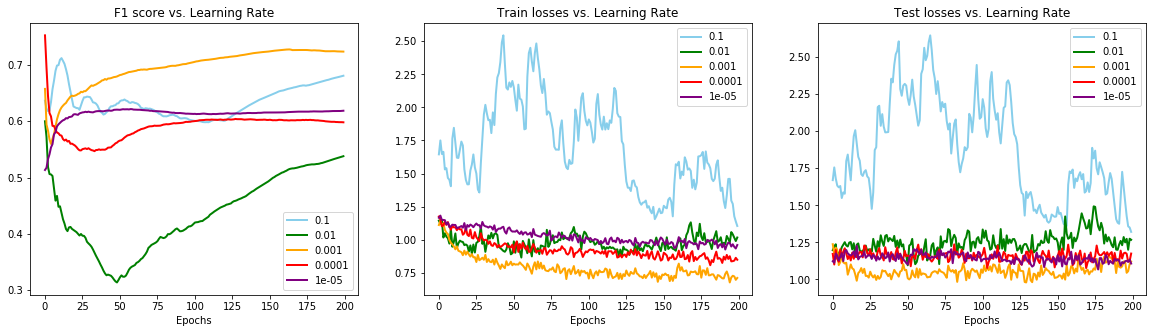

In [19]:
%run trainRNN_plot_utils.py
plot_inputs(F1_scores, trainLosses, testLosses, n_epoch, "Learning Rate")

In [15]:
# SAVE DATA
# Save the created samples, such tha the NNs can load them easily

# Save data into Python file
import pickle
with open('resultsEncoderLearningRate_HBTRC.pickle', 'wb') as f:
    pickle.dump( trainLosses, f, pickle.HIGHEST_PROTOCOL )
    pickle.dump( testLosses, f, pickle.HIGHEST_PROTOCOL )
    pickle.dump( F1_scores, f, pickle.HIGHEST_PROTOCOL )
    pickle.dump( trainAccuracy, f, pickle.HIGHEST_PROTOCOL )
    print( 'Data saved into pickle.' )

Data saved into pickle.
